# Molecular Properties Prediction
Author: Hyunwook Paul Shin

<img src="Image/molecules.png" width="80%" height="80%">

## 1. Overview

This notebook contains the steps of solving the molecular properties prediction involving the molecular structural data. The aim of the project is to create a model that can provide the accurate prediction on the target variable, scalar coupling constant. Since this is a prediction on the continous quantity output, the problem is defined as the regression problem. Then, the metrics are set as R-squared score, root mean squared error, and mean absolute error to evaluate the regression model: goal is to enhance the R2 score while maintaining the low error values. After performing multiple modeling, the Random Forest Regression is selected as the best model. 

## 2. Business Problem

Nuclear Magnetic Resonance (NMR) is a core technique used to understand the structure and interactions of the molecules and proteins. NMR is being utilized by the researchers in pharmaceutical and chemical field worldwide. The NMR performance is largely dependent on the accurate prediction on the variable, scalar coupling constant (SCC). 

SCC is a magnetic interaction (also called 'coupling') between two atoms. It is the feature that provides information on the connectivity of chemical structure which is used to explain the interaction between the molecules in NMR. However, the constraint in SCC calculation limits the application of this technique; the calculation length takes from days to even weeks for one molecule when the structural information of the molecule is an input and the cost of calculation is expensive.

Therefore, creating a model that can accurately predict the SCC will allow the NMR to be applicable for research in daily basis. The model will allow the phamceutical researchers to gain insight on how the molecular structure affects the properties and behavior faster and cheaper, and accelerate the innovation in inventing and designing new drugs.


### Stakeholder
Pharmaceutical Researchers
 
### Goal 
Develop a regression model that predicts the scalar coupling constant from the structural information of the molecule. 

### Metrics
For evaluation, we will look at the following metrics:
- R2 Score
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)

Better model will show higher R2 score while showing lower RMSE and MAE values.

## 3. Data Understanding

The dataset used for this prediction modeling was sourced from https://www.kaggle.com/c/champs-scalar-coupling/data. Following is the description of the dataset we will be using for the analysis.

- train.csv
    - the training set, where the first column (molecule_name) is the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz), the second (atom_index_0) and third column (atom_index_1) is the atom indices of the atom-pair creating the coupling and the fourth column (scalar_coupling_constant) is the scalar coupling constant that we want to be able to predict

- structures.csv 
    - this file contains the same information as the individual xyz structure files, but in a single file

Provided test.csv will not be used for analysis since it does not provide target variable, and, therefore, it cannot be used to check the accuracy of the result of the model. Instead, we will split the train.csv into train, test, and validation set. 

Before starting the data analysis, lets import the libraries and tools that will be used for the whole process.

In [1]:
#!pip install lightgbm

In [2]:
#!pip install CatBoost

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization 
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings("ignore")

### 3.1 Load Dataset

Goal of the project is to predict scalar coupling constant of the molecule by its structure. Therefore, we will use the train.csv and structures.csv. Lets load those two files as dataframes and check the contents.

In [52]:
# Import the data: train set and structures
train_df = pd.read_csv('Data/train.csv')
structures_df = pd.read_csv('Data/structures.csv')

In [53]:
# Observe traindf
print('Data Shape')
print(train_df.shape)
print('')
print('Number of Unique Entries')
print(train_df.nunique())
print('')
print('List of Columns')
print(train_df.columns)
train_df.head()

Data Shape
(4659076, 6)

Number of Unique Entries
id                          4659076
molecule_name                 85012
atom_index_0                     28
atom_index_1                     29
type                              8
scalar_coupling_constant    2183446
dtype: int64

List of Columns
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [54]:
# Observe structures_df
print('Data Shape')
print(structures_df.shape)
print('')
print('Number of Unique Entries')
print(structures_df.nunique())
print('')
print('List of Columns')
print(structures_df.columns)
structures_df.head()

Data Shape
(2358875, 6)

Number of Unique Entries
molecule_name     130789
atom_index            29
atom                   5
x                2358802
y                2358808
z                2358792
dtype: int64

List of Columns
Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z'], dtype='object')


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


There are two atom_indexes in train_df while only one exists in structures_df. It seems like type of atom and 3-Dimensional position information varies based on the atom_index.

### 3.2 Exploratory Data Analysis (EDA)

We will check the distribution of the features in this section.

#### Scalar Coupling Constant (Target)

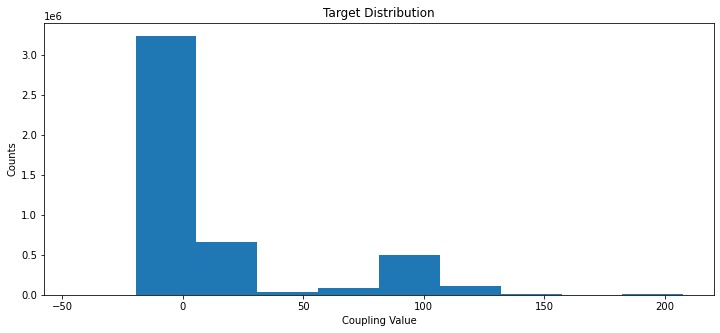

In [252]:
# Check the Distribution of Target Variable
fig, ax = plt.subplots(figsize=(12,5))

# Plot histogram of scalar_coupling_constant
ax.hist(train_df['scalar_coupling_constant'])

# set titles and axis labels
ax.set_title('Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Target_Distribution')

Target variable distributes from -50 to 250. It is imbalanced: Most of the variables are concentrated between -50 to 50. This target variable seems to have right-skewed distribution.

Since the target variable is not normally distributed, we will try cubic root transformation of the target variable.

Logistic transformation and square root transformation is also the good option in handling the skewed distribution. However, since the logarithm and square root is only defined for positive numbers, you can't take the logarithm of negative values. This means logistic transformation cannot be applied on our target variable which contains negative values.

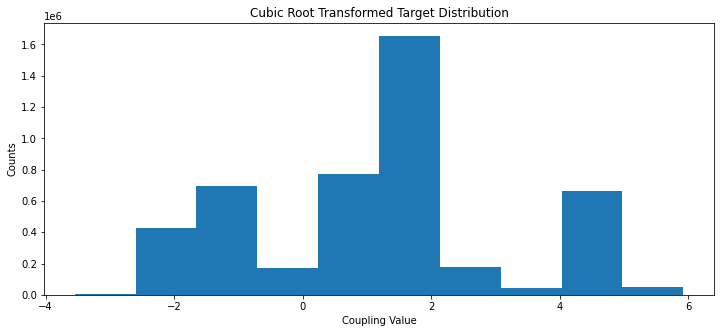

In [253]:
# Create a figure
fig, ax = plt.subplots(figsize=(12,5))

# Plot histogram of cubic root transformed scalar_coupling_constant
ax.hist(np.cbrt(train_df['scalar_coupling_constant']))

# set titles and axis labels
ax.set_title('Cubic Root Transformed Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Normalized_Target_Distribution')

The cubic root transformation seems to express good performance on normalizing the data. Now the data is more normally distributed between -4 and 6.

#### Types of Coupling

There are multiple types of couplings in chemical field. Lets check how many types of coupling listed in the dataset.

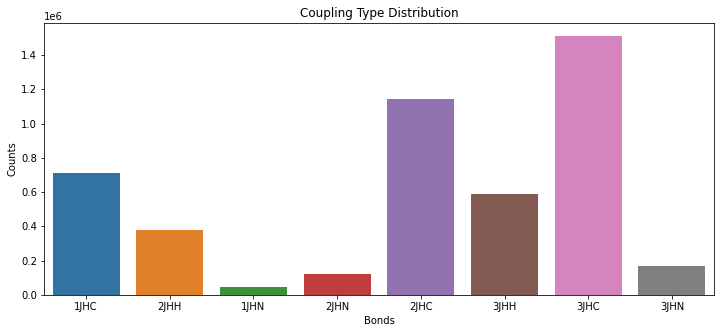

In [254]:
# Check the type of bonds
fig, ax = plt.subplots(figsize=(12,5))

# plot the counts of values for each coupling type
ax = sns.countplot(x='type', data=train_df)

# set titles and axis labels
ax.set_title('Coupling Type Distribution')
ax.set_xlabel('Bonds')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Coupling_types')

There are total 8 different bonds types. The different bond type also represents the different interaction between the atoms which is a crucial information in predicting scalar coupling constant.

#### Atom Index

In this section, we will see what is the atom_indexes in train_df and structures_df.

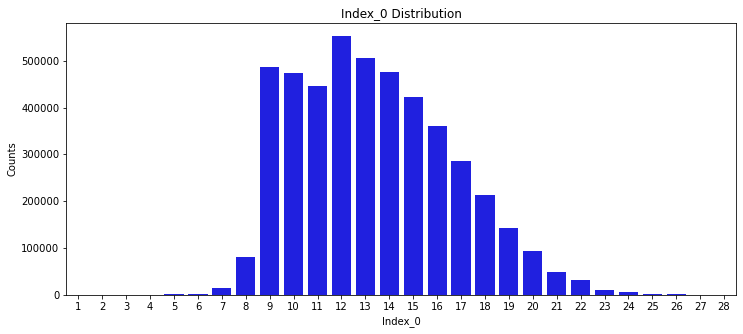

In [255]:
# Instantiate the figure
fig, ax = plt.subplots(figsize=(12,5))

# plot the counts of values for atom_index_0
ax = sns.countplot(x='atom_index_0', data=train_df, color = 'blue')

# set titles and axis labels
ax.set_title('Index_0 Distribution')
ax.set_xlabel('Index_0')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Atom_Index_0_Distribution')

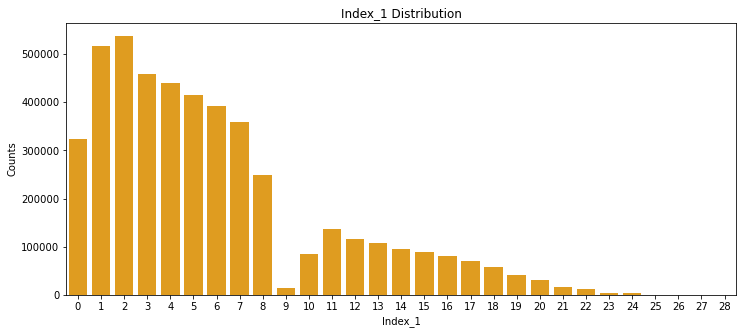

In [256]:
# Instantiate the figure
fig, ax = plt.subplots(figsize=(12,5))

# plot the counts of values for atom_index_1
ax = sns.countplot(x='atom_index_1', data=train_df, color = 'orange')

# set titles and axis labels
ax.set_title('Index_1 Distribution')
ax.set_xlabel('Index_1')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Atom_Index_1_Distribution')

We can see that the Index_0 has its highest count between 9 and 17~18, while Index_1 has its highest count between 0 and 8. Although it is skewed, this is rather a categorical column than numerical column, therefore, log transformation is not needed. 

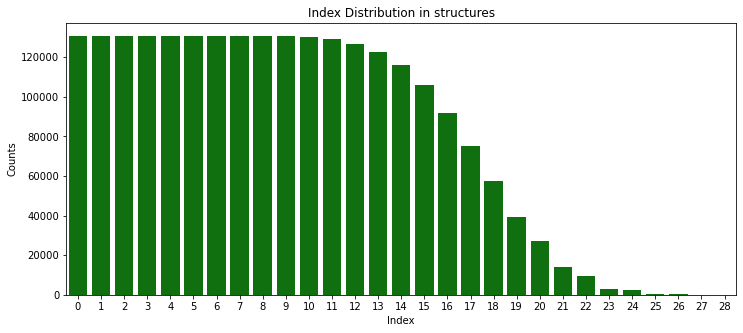

In [257]:
# Instantiate the figure
fig, ax = plt.subplots(figsize=(12,5))

# plot the counts of values for atom_index in structures_df
ax = sns.countplot(x='atom_index', data=structures_df, color = 'green')

# set titles and axis labels
ax.set_title('Index Distribution in structures')
ax.set_xlabel('Index')
ax.set_ylabel('Counts')

# save figure
fig.savefig('Image/Structures_Atom_Index_Distribution')

In structures_df, atom_index has highest count between 0 and 10 and slowly reduces after on.

All three columns share the same range of atom index. Therefore, atom index will be a key column when merging the train_df and structures_df.

## 4. Data Preparation

In this section, we will:
- Merge train_df and structures_df
- Create new features, such as distance and angle of the bond
- Normalize the target variable
- Check the multicollinearity of each columns
- Split the dataset into train, test, and validation set
- Perform preprocessing

### 4.1 Merge Train and Structure

This merging technique has been sourced from: https://www.kaggle.com/inversion/atomic-distance-benchmark.

As we can see from EDA for the atom_index, train_df has two atom_index columns, while the structures_df has only one. This is because train_df contains the infromation on the bond between two atoms, and structures_df contains the information on the position of one atom inside the molecule. Therefore, merging process has to be done twice: once for each atom in the bond. Since the same preprocess is being used twice, we will create a function to speed up the process.

In [61]:
def map_atom_info(df, atom_idx):
    '''
    This function merges the input df with the structures information df based on atom_idx input.
    There are two atom indexes in the df: 0 and 1. 
    Structure information will be merged to input df, and the contents will be renamed based on atom_idx.
    
    Need of this function:
    Each row of input df contains the bond information of the two atoms.
    Each row of structures_df only contains the position information of one atom in a molecule.
    We need position information for both atoms in input df, however, merging once will only provide the information of one atom.
    
    Therefore, using this function twice (once on 'atom_index_0' and once on 'atom_index_1') will 
    allow the final_df to have position information for both atoms in a row.
    
    
    Input:
    df: pandas dataframe
    atom_idx: 0 or 1
    
    Output:
    merged dataframe
    '''
    # Merge dataframe
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    # Rename the columns
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [204]:
# Merge train and structures
train_df2 = map_atom_info(train_df, 0)
train_df2 = map_atom_info(train_df2, 1)
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [205]:
# check nan after merging
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dtype: int64

There are no NAN values, and the merging was done successfully.

### 4.2 Feature Engineering

Now, we will work on feature engineering and create new columns that might help us generate more accurate prediction.

#### 4.2.1 Distance between Atoms

In this step, we will use position information of atoms and create columns related to distance between atoms.

First will be the distance between atoms. For 3-Dimensional distance calculation we use the following equation:
<img src="Image/3d_distance_formula.png" width="50%" height="50%">


In [206]:
# Calculate the 3D distance between atom
train_df2['distance'] = ((train_df2['x_0']-train_df2['x_1'])**2 +
(train_df2['y_0']-train_df2['y_1'])**2 + (train_df2['z_0']-train_df2['z_1'])**2)**0.5

train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


Next, we will create a column 'dist_to_type_mean' which is found by dividing the distance we calculated above by the mean distance of corresponding bond type.

In [207]:
train_df2['dist_to_type_mean'] = train_df2['distance'] / train_df2.groupby('type')['distance'].transform('mean')
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132


#### 4.2.2 Coupling Angle

Angle of the coupling of atoms is an important feature in coupling constant calculation. Therefore, calculating and adding bond angle as a feature has high possibility to positively affect the prediction accuracy. Feature engineering technique for bond angle is sourced from https://www.kaggle.com/kmat2019/effective-feature.

In [208]:
def angle_info(df):
    '''
    This function calculates and adds the cosine angle between the molecules to the input df and returns the revised version of input df.
    
    Input:
    df: pandas dataframe
    
    Output:
    Revised version of input df
    '''
    
    # Create new df (new_atom) with new atom position & distance info 
    new_atom = train_df2.loc[:,["molecule_name","atom_index_0","atom_index_1","distance","x_0","y_0","z_0","x_1","y_1","z_1"]]
    
    # Create a dataset with original and reversed positional information
    # Necessary step for angle calculation since we need reversed postion info
    new_atom2 =new_atom.copy()
    new_atom2 = new_atom2.rename(columns={'atom_index_0': 'atom_index_1',
                                   'atom_index_1': 'atom_index_0',
                                   'x_0': 'x_1',
                                   'y_0': 'y_1',
                                   'z_0': 'z_1',
                                   'x_1': 'x_0',
                                   'y_1': 'y_0',
                                   'z_1': 'z_0'})
    
    # Merging datasets with original and reversed postion
    new_atom = pd.concat((new_atom, new_atom2), axis=0)
    
    # Find the minimum distance for atom_index_0
    new_atom['min_distance'] = new_atom.groupby(['molecule_name', 'atom_index_0'])['distance'].transform('min')
    
    # Leave the columns where distance = minmum distance for that atom_index
    new_atom = new_atom[new_atom['min_distance'] == new_atom['distance']]
    
    # drop the column unneccessary columns
    new_atom = new_atom.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    
    # Rename features
    # New atoms will be named as atom_closest
    new_atom = new_atom.rename(columns={'atom_index_0': 'atom_index',
                                 'atom_index_1': 'atom_index_closest',
                                 'distance': 'distance_closest',
                                 'x_1': 'x_closest',
                                 'y_1': 'y_closest',
                                 'z_1': 'z_closest'})
    
    # merge new_atom with input df
    # same logic with the function map_atom_info
    # since there are two indexes, we need to apply same logic twice
    atom_idx = 0
    angle_df = pd.merge(train_df2, new_atom, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
        
    angle_df = angle_df.drop('atom_index', axis=1)
    angle_df = angle_df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    atom_idx2 = 1
    angle_df = pd.merge(angle_df, new_atom, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx2}'],
                  right_on = ['molecule_name',  'atom_index'])
        
    angle_df = angle_df.drop('atom_index', axis=1)
    angle_df = angle_df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx2}',
                                        'distance_closest': f'distance_closest_{atom_idx2}',
                                        'x_closest': f'x_closest_{atom_idx2}',
                                        'y_closest': f'y_closest_{atom_idx2}',
                                        'z_closest': f'z_closest_{atom_idx2}'})
        
    # calculate new distances
    angle_df["distance_0"]=((angle_df['x_0']-angle_df['x_closest_0'])**2+(angle_df['y_0']-angle_df['y_closest_0'])**2+(angle_df['z_0']-angle_df['z_closest_0'])**2)**(1/2)
    angle_df["distance_1"]=((angle_df['x_1']-angle_df['x_closest_1'])**2+(angle_df['y_1']-angle_df['y_closest_1'])**2+(angle_df['z_1']-angle_df['z_closest_1'])**2)**(1/2)
    
    # calculate vectors between atom 0 and atom closest to 0
    angle_df["vec_0_x"]=(angle_df['x_0']-angle_df['x_closest_0'])/angle_df["distance_0"]
    angle_df["vec_0_y"]=(angle_df['y_0']-angle_df['y_closest_0'])/angle_df["distance_0"]
    angle_df["vec_0_z"]=(angle_df['z_0']-angle_df['z_closest_0'])/angle_df["distance_0"]
    
    # calculate vectors between atom 1 and atom closest to 1
    angle_df["vec_1_x"]=(angle_df['x_1']-angle_df['x_closest_1'])/angle_df["distance_1"]
    angle_df["vec_1_y"]=(angle_df['y_1']-angle_df['y_closest_1'])/angle_df["distance_1"]
    angle_df["vec_1_z"]=(angle_df['z_1']-angle_df['z_closest_1'])/angle_df["distance_1"]
    
    # calculate vectors between atom 0 and 1
    angle_df["vec_x"]=(angle_df['x_1']-angle_df['x_0'])/angle_df["distance"]
    angle_df["vec_y"]=(angle_df['y_1']-angle_df['y_0'])/angle_df["distance"]
    angle_df["vec_z"]=(angle_df['z_1']-angle_df['z_0'])/angle_df["distance"]  
    
    # calculate the cosine angle between:
    # 1. atom 0 and 1 / 2. atom 0 and atom closest to 0 / 3. atom 1 and atom closest to 1
    angle_df["cos_0_1"]=angle_df["vec_0_x"]*angle_df["vec_1_x"]+angle_df["vec_0_y"]*angle_df["vec_1_y"]+angle_df["vec_0_z"]*angle_df["vec_1_z"]
    angle_df["cos_0"]=angle_df["vec_0_x"]*angle_df["vec_x"]+angle_df["vec_0_y"]*angle_df["vec_y"]+angle_df["vec_0_z"]*angle_df["vec_z"]
    angle_df["cos_1"]=angle_df["vec_1_x"]*angle_df["vec_x"]+angle_df["vec_1_y"]*angle_df["vec_y"]+angle_df["vec_1_z"]*angle_df["vec_z"]
    
    # Leave necessary columns only
    angle_df = angle_df.loc[:,['molecule_name', 'atom_index_0','atom_index_1','type', 'cos_0_1','cos_0', 'cos_1']]
    
    # Merge with input df
    df = pd.merge(df, angle_df, on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])
    
    return df

In [209]:
# Perform angle calculation
train_df2 = angle_info(train_df2)

In [210]:
# check the final version of the dataset
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,0.333335,-1.000000,-0.333335
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647,-0.333287,-0.816483,0.816482
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663,-0.333335,-0.816498,0.816496
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668,-0.333347,-0.816502,0.816500
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132,0.333352,-1.000000,-0.333352


Now, lets check if there is any NAN values in added features.

In [211]:
# check the NAN values of the final dataset
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
distance                    0
dist_to_type_mean           0
cos_0_1                     0
cos_0                       0
cos_1                       0
dtype: int64

We can see that there are no NAN values in the dataset and the feature engineering was done correctly.

### 4.3 Normalization

As we found out in EDA process, target variable ('scalar_coupling_constant') has a right skewed distribution, and it showed more normalized distribution after cubic root transformation. Therefore, we will apply cubic root transformation on the 'scalar_coupling_constant.'

In [212]:
# create new target variable 'cbrt_scalar_coupling_constant'
train_df2['cbrt_scalar_coupling_constant'] = np.cbrt(train_df2['scalar_coupling_constant'])

# check the train_df2
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1,cbrt_scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,0.333335,-1.000000,-0.333335,4.393510
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647,-0.333287,-0.816483,0.816482,-2.241167
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663,-0.333335,-0.816498,0.816496,-2.241021
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668,-0.333347,-0.816502,0.816500,-2.240988
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132,0.333352,-1.000000,-0.333352,4.393506


Now, we will drop the old target variable 'scalar_coupling_constant' and use 'cbrt_scalar_coupling_constant' as our target variable for regression analysis.

In [213]:
# drop 'scalar_coupling_constant'
train_df2.drop(columns = ['scalar_coupling_constant'], inplace = True)

train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659076 entries, 0 to 4659075
Data columns (total 19 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   molecule_name                  object 
 2   atom_index_0                   int64  
 3   atom_index_1                   int64  
 4   type                           object 
 5   atom_0                         object 
 6   x_0                            float64
 7   y_0                            float64
 8   z_0                            float64
 9   atom_1                         object 
 10  x_1                            float64
 11  y_1                            float64
 12  z_1                            float64
 13  distance                       float64
 14  dist_to_type_mean              float64
 15  cos_0_1                        float64
 16  cos_0                          float64
 17  cos_1                          float64
 18  cb

### 4.4 Multicollinearity

Now, lets create a heatmap and find the columns with multicollinearity. 

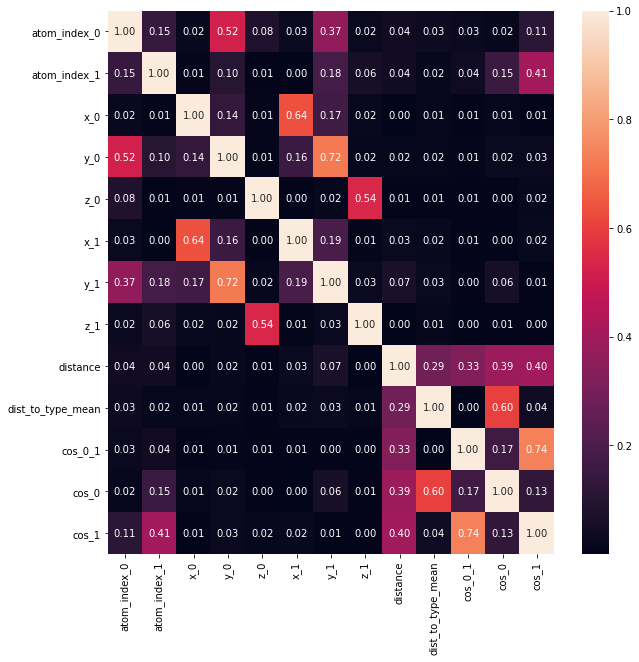

In [258]:
# Visualize the multicollinearity 
# Use heatmap from seaborn
# Set correlation score absolute value and round up to 2 digit
heatmap_df = train_df2.drop(columns=['id', 'molecule_name', 'cbrt_scalar_coupling_constant'])
plt.figure(figsize = (10,10))
sns.heatmap(heatmap_df.corr().abs(), annot = True, fmt='.2f')

# save figure
plt.savefig('Image/Multicollinearity')

Rule of thumb for multicolinearity:
- If the correlation > 0.8, then severe multicollinearity may be present.

None of the multicollinearity score is above 0.8, and, therefore, we can conclude there is no severe multicollinearity.

### 4.5 Train Test Split

We will split the train_df2 into X and y. We will exclude columns id and molecule_name 
- X: All columns else than trarget variable(scalar_coupling_constant), id, and molecule_name

    - We will exclude columns id and molecule_name since those two does not contribute to the scalar coupling constant.
    
    
- y: target variable (scalar_coupling_constant)

We will conduct train test split twice to create train set, validation set, and test set. The ratio for this split will be 60% for train, 20% for validation and test, which is one of the common ratios. 

This is also because our dataset is huge: it has more than 4 million rows. By reducing the size of the test set, we will be able to speed up the modeling process.

In [214]:
def ttv_split(df):
    '''
    This function splits the set of dataframe into train, validation, and test set with ration of 60:20:20.
    
    Input:
    df: Pandas Dataframe
    
    Output:
    X_train
    X_test 
    X_val 
    y_train 
    y_test
    y_val
    '''
    # Create X and y from df input
    X = df.drop(columns = ['id', 'molecule_name', 'cbrt_scalar_coupling_constant'])
    y = df[['cbrt_scalar_coupling_constant']]
    
    # Split into train and test
    # ratio train 80% : test 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 1)
    
    # Split into train and val
    # ratio train 60% : val 20% : test 20%
    # to achieve this test_size should be 1/4 = 0.25
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state =1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [215]:
# conduct train, test, val split for each subset
X_train, X_test, X_val, y_train, y_test, y_val = ttv_split(train_df2)

In [216]:
# check the train set for c1 subset
X_train.shape

(2795445, 16)

In [217]:
# check the validation set for c1 subset
X_val.shape

(931815, 16)

In [218]:
X_test.shape

(931816, 16)

Great! Test and validation set has almost same amount of rows. Also, train set has smount of rows 3 times larger than validation and test set. 

Train - test - validation split was successful.

In [219]:
X_train_backup = X_train.copy()
X_val_backup = X_val.copy()
X_test_backup =  X_test.copy()

### 4.6 Preprocessing

First, we will divide up the columns into numerical and categorical. For this process, we will create a new copy of train_df2 (final dataset). Since the preprocessing is only applied for the the X set, we will exclude the following columns so the we can preprocess the columns in X sets only:
- scalar coupling constant (target variable)
- id
- molecule name

In [220]:
# Create a train_df3
# exclude scalar_coupling_constant, id, molecule_name, and type
train_df3 = train_df2.drop(columns=['cbrt_scalar_coupling_constant', 'id', 'molecule_name'])

In [221]:
# check the dataframe
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659076 entries, 0 to 4659075
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   atom_index_0       int64  
 1   atom_index_1       int64  
 2   type               object 
 3   atom_0             object 
 4   x_0                float64
 5   y_0                float64
 6   z_0                float64
 7   atom_1             object 
 8   x_1                float64
 9   y_1                float64
 10  z_1                float64
 11  distance           float64
 12  dist_to_type_mean  float64
 13  cos_0_1            float64
 14  cos_0              float64
 15  cos_1              float64
dtypes: float64(11), int64(2), object(3)
memory usage: 604.3+ MB


In [222]:
# instantiate lists of columns
num_cols = []
cat_cols = []

# num = any columns with numerical value
# cat = everything else
for c in train_df3.columns:
    if train_df3[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [223]:
# check numerical columns
num_cols

['atom_index_0',
 'atom_index_1',
 'x_0',
 'y_0',
 'z_0',
 'x_1',
 'y_1',
 'z_1',
 'distance',
 'dist_to_type_mean',
 'cos_0_1',
 'cos_0',
 'cos_1']

In [224]:
# check categorical columns
cat_cols

['type', 'atom_0', 'atom_1']

We will create a function for preprocessing. Scaler and encoder we will use for this process are:
- MinMaxScaler: Numerical columns
- LabelEncoder: Categorical columns

In [227]:
def preprocess(X_tr, X_te, X_v):

    # Scale and Encode Separated Columns
    for i in num_cols:
        X_tr[[i]] = scaler.fit_transform(X_tr[[i]]) 
        X_te[[i]] = scaler.transform(X_te[[i]]) 
        X_v[[i]] = scaler.transform(X_v[[i]]) 
    
    for f in cat_cols:
        X_tr[f] = encoder.fit_transform(X_tr[[f]])
        X_te[f] = encoder.transform(X_te[[f]])
        X_v[f] = encoder.transform(X_v[[f]])

In [229]:
# perform preprocessing
preprocess(X_train, X_test, X_val)

Not lets check the preprocessed datasets.

In [234]:
X_train.describe()

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1
count,2.795445e+06,2.795445e+06,2.795445e+06,2795445.0,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06,2.795445e+06
mean,4.575517e-01,2.100649e-01,3.477557e+00,0.0,5.017261e-01,4.828783e-01,5.415220e-01,3.494381e-01,5.285328e-01,4.711275e-01,5.309035e-01,4.664676e-01,5.581355e-01,4.557894e-01,2.186615e-01,5.455264e-01
std,1.210971e-01,1.783643e-01,2.112027e+00,0.0,9.438957e-02,1.054225e-01,9.455198e-02,6.072796e-01,8.364859e-02,9.809802e-02,7.774892e-02,2.529564e-01,1.187310e-01,3.022098e-01,1.799235e-01,3.209953e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.703704e-01,7.142857e-02,2.000000e+00,0.0,4.448524e-01,4.026563e-01,4.803280e-01,0.000000e+00,4.781990e-01,4.040887e-01,4.848351e-01,3.248948e-01,5.044550e-01,1.983721e-01,9.330080e-02,2.875541e-01
50%,4.444444e-01,1.785714e-01,4.000000e+00,0.0,5.031607e-01,4.790321e-01,5.388222e-01,0.000000e+00,5.256507e-01,4.648607e-01,5.268786e-01,4.502085e-01,5.574367e-01,4.500961e-01,1.808470e-01,4.880223e-01
75%,5.555556e-01,2.857143e-01,5.000000e+00,0.0,5.618812e-01,5.809790e-01,6.011493e-01,1.000000e+00,5.776998e-01,5.091522e-01,5.813568e-01,6.673817e-01,6.083306e-01,6.922455e-01,3.028655e-01,9.000733e-01
max,1.000000e+00,1.000000e+00,7.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [231]:
X_test.describe()

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1
count,931816.000000,931816.000000,931816.000000,931816.0,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,931816.000000,9.318160e+05
mean,0.457935,0.209947,3.476025,0.0,0.501719,0.482678,0.541625,0.348567,0.528563,0.470909,0.531079,0.466409,0.558093,0.455805,0.218561,5.453363e-01
std,0.121180,0.178206,2.112240,0.0,0.094356,0.105299,0.094643,0.606858,0.083605,0.098077,0.077805,0.252953,0.118680,0.302513,0.179910,3.209738e-01
min,0.000000,0.000000,0.000000,0.0,0.000000,0.025828,0.025021,0.000000,0.075061,0.010866,0.016555,0.000020,0.008217,0.000000,0.000000,2.590368e-09
25%,0.370370,0.071429,2.000000,0.0,0.444862,0.402488,0.480386,0.000000,0.478436,0.403792,0.485068,0.324983,0.504658,0.197318,0.092914,2.873404e-01
50%,0.444444,0.178571,4.000000,0.0,0.503259,0.478915,0.538843,0.000000,0.525681,0.464828,0.526881,0.450411,0.557469,0.450023,0.180874,4.879464e-01
75%,0.555556,0.285714,5.000000,0.0,0.561884,0.580850,0.601381,1.000000,0.577641,0.508380,0.581574,0.667632,0.608356,0.692648,0.303380,9.000352e-01
max,1.000000,1.000000,7.000000,0.0,1.000000,1.000000,1.001313,2.000000,0.986876,0.974058,0.977822,0.999892,0.999833,1.000000,0.910907,1.000000e+00


In [232]:
X_val.describe()

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,cos_0_1,cos_0,cos_1
count,931815.000000,931815.000000,931815.000000,931815.0,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,931815.000000,9.318150e+05
mean,0.457701,0.210080,3.477921,0.0,0.501737,0.482701,0.541598,0.349411,0.528552,0.470884,0.530917,0.466528,0.558118,0.455326,0.218886,5.458248e-01
std,0.120979,0.178451,2.111354,0.0,0.094303,0.105369,0.094576,0.607163,0.083560,0.098154,0.077818,0.252823,0.118694,0.302194,0.180002,3.210596e-01
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025021,0.000000,0.000902,0.010866,0.016555,0.000062,0.039522,0.000000,0.000000,1.984741e-09
25%,0.370370,0.071429,2.000000,0.0,0.444855,0.402465,0.480355,0.000000,0.478223,0.403277,0.484774,0.324981,0.504403,0.197521,0.093430,2.875592e-01
50%,0.444444,0.178571,4.000000,0.0,0.503294,0.478872,0.538856,0.000000,0.525656,0.464755,0.526878,0.450308,0.557447,0.449726,0.180960,4.884859e-01
75%,0.555556,0.285714,5.000000,0.0,0.561774,0.580859,0.601337,1.000000,0.577836,0.508698,0.581298,0.667657,0.608348,0.691760,0.304477,9.003402e-01
max,1.000000,1.000000,7.000000,0.0,0.941437,0.976760,1.001313,2.000000,0.985173,0.964674,0.977822,0.990558,0.988751,1.000000,0.941061,1.000000e+00


All three datasets are preprocessed successfully.

## 5. Modeling

There are multiple options of models for solving the regression problem. In this project the machine learning models we will be using are:
- Linear Regression
- Random Forest 
- XGBoost
- Light Gradient Boost (LGBM)
- CatBoost
- Keras Neural Networks

After the modeling is done, models will be evaluated. Models will be selected based on the performance on the validation set.
- Highest R2 Score
- Lowest RMSE and MAE

Since the multiple modeling will be done, we will create function for fitting and evaluating the model to speed up the process.

In [235]:
def fit_and_eval(regressor, X_tr, y_tr, X_v, y_v):
    '''
    This function:
    1. Creates the model based on input regressor 
    2. Fits the model
    3. Predict the values based on fitted model
    4. Report the model training time in seconds
    6. Report the results for evaluation (R2 score, Root Mean Squared Error (RMSE), Mean Absolute Error(MAE))
    7. Plot the scatter plot of prediction on validation set with best fit line 
    8. Return fitted model
    
    Input:
    regressor: machine learning model ( ex) LinearRegression(), RandomForestRegressor(), ... )
    X_tr: train dataset for features (X)
    y_tr: train dataset for target variable (y)
    X_v: validation dataset for features (X)
    y_v: validation dataset for target variable (y)    
    
    Output:
    Training Time: seconds
    Result Report
    Scatter Plot
    Fitted model
    '''
    # Create model with pipeline
    model = regressor
    
    # Record the fitting start time
    start = time.time()
    
    # Fit the model
    model.fit(X_tr, y_tr)
    
    # Record the fitting end time
    stop = time.time()
    
    # Return Training time in seconds
    print(f"Training time: {stop - start}s")
    
    # Predict on train and validation set
    tr_pred = model.predict(X_tr)
    val_pred = model.predict(X_v)
    
    # Report Results (R2, RMSE, MAE)
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Train MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    
    # Plot the validation prediction and best fit line
    plt.scatter(y_v,val_pred)
    plt.plot(y_v, y_v, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    
    return model

### 5.1 First Simple Model

Out of the lists of model, most simple model is Linear Regression. To understand our baseline, we will start off with the Linear Regression Model.

Training time: 0.986212968826294s
Result Report

Train R2 Score: 0.5477311058147756
Validation R2 Score: 0.548706821594784

Train RMSE: 1.3327943321092197
Validation RMSE: 1.331348789721334

Train MAE: 1.0496662747341228
Validation MAE: 1.0480847250784242


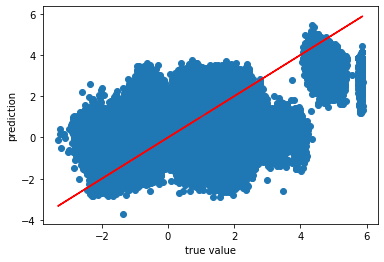

In [236]:
lr_model = fit_and_eval(LinearRegression(), X_train, y_train, X_val, y_val)

#### Evaluation

Results on the validation set:

- R2 score: 0.549
- RMSE: 1.331
- MAE: 1.048
- Training Time: about 1 second 

The linear regression showed a decent performance considering the model is a first simple model. The result shows that there is no overfitting. R2 score of 0.549 is a moderate score. RMSE and MAE is fairly low considering the range of the normalized target variable, which is between -4 and 6. However, since there are more complex models, which has potential of giving better result. Overall, this is a good starting point.

### 5.2 Random Forest Regressor

Second model is Random Forest Regressor. Since we still have huge dataset even after splitting, we will limit the hyperparameter, max_depth, to reduce the modeling time.  

Training time: 3299.6762590408325s
Result Report

Train R2 Score: 0.9109613464972038
Validation R2 Score: 0.9107938589564958

Train RMSE: 0.591362892472923
Validation RMSE: 0.5919156731890656

Train MAE: 0.3598018288879159
Validation MAE: 0.3602428989939122


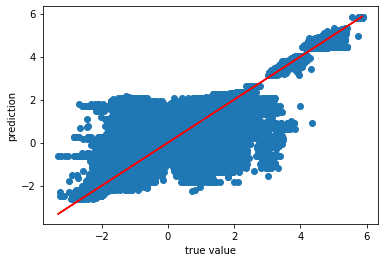

In [242]:
rf_model = fit_and_eval(RandomForestRegressor(max_depth = 10), X_train, y_train, X_val, y_val)

#### Evaluation

Results on the validation set:

- R2 score: 0.911
- RMSE: 0.592
- MAE: 0.360
- Training Time: 3300 seconds (about 1 hour)

The Random Forest regression shows better performance than linear regression model. R2 score of 0.911 is higher than R2 score of linear regression. RMSE and MAE also became almost half compared to the linear regression. One disadvantage of this model is that the fitting time was very long: It took about an hour for modeling even though the max depth was limited to 10.

### 5.3 XGB Regressor

Third model is X Gradient Boost (XGB) regressor.

Training time: 167.75719714164734s
Result Report

Train R2 Score: 0.9305440956226718
Validation R2 Score: 0.9293570714932649

Train RMSE: 0.5222992026869764
Validation RMSE: 0.5267406201015526

Train MAE: 0.3165534151092136
Validation MAE: 0.31891799366996837


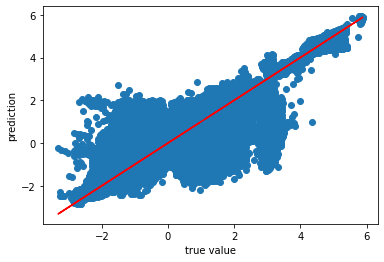

In [239]:
XGB_model = fit_and_eval(XGBRegressor(), X_train, y_train, X_val, y_val)

#### Evaluation

Results on the validation set:

- R2 score: 0.929
- RMSE: 0.527
- MAE: 0.319
- Training time: 167 seconds (= 3 minutes)

The XGB regression shows better performance than Random Forest regression model. R2 score of 0.929 is higher than R2 score of Random Forest regression. RMSE and MAE also got slightly lower compared to the error values of Random Forest. Also, there is no sign of overfitting since the train result and validation result are almost equal. The modeling time was faster than Random Forest: It took about 3 minutes for modeling.

### 5.4 LGBM Regressor


Fourth model is light gradient boosting machine (LGBM) regressor.

Training time: 6.271471738815308s
Result Report

Train R2 Score: 0.9193418933338546
Validation R2 Score: 0.9191632159428268

Train RMSE: 0.5628449699800792
Validation RMSE: 0.5634650420547318

Train MAE: 0.35142075275538476
Validation MAE: 0.35161478174196326


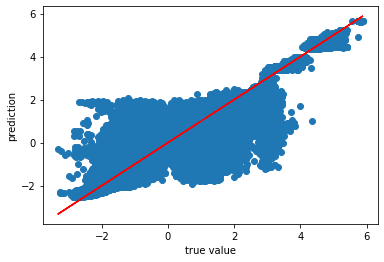

In [240]:
LGBM_model = fit_and_eval(LGBMRegressor(), X_train, y_train, X_val, y_val)

#### Evaluation

Results on the validation set:

- R2 score: 0.919
- RMSE: 0.563
- MAE: 0.352
- Training time: 6 seconds

The XGB regression shows slightly worse performance than XGB regression model. R2 score of 0.919 is higher than R2 score of Random Forest regression but lower than that of XGB Regressor. RMSE and MAE also got slightly higher compared to the error values of XGB Regressor. Also, there is no sign of overfitting since the train result and validation result are almost equal. The modeling time was extremely fast: It took about 6 seconds for modeling.

### 5.5 CatBoost Regressor

Since there are some categorical columns, and some of the numerical columns, such as atom_index_0 and atom_index_1, are showing more of a categorical beahviour, we will try out the Categorical Boost (CatBoost) Regressor.

Learning rate set to 0.143456
0:	learn: 1.7399162	total: 260ms	remaining: 4m 19s
1:	learn: 1.5373532	total: 478ms	remaining: 3m 58s
2:	learn: 1.3684001	total: 681ms	remaining: 3m 46s
3:	learn: 1.2280345	total: 880ms	remaining: 3m 39s
4:	learn: 1.1132925	total: 1.08s	remaining: 3m 35s
5:	learn: 1.0205687	total: 1.28s	remaining: 3m 32s
6:	learn: 0.9450568	total: 1.49s	remaining: 3m 30s
7:	learn: 0.8853564	total: 1.69s	remaining: 3m 29s
8:	learn: 0.8383473	total: 1.88s	remaining: 3m 27s
9:	learn: 0.8008073	total: 2.08s	remaining: 3m 25s
10:	learn: 0.7716652	total: 2.26s	remaining: 3m 23s
11:	learn: 0.7484452	total: 2.47s	remaining: 3m 23s
12:	learn: 0.7297759	total: 2.68s	remaining: 3m 23s
13:	learn: 0.7158174	total: 2.88s	remaining: 3m 23s
14:	learn: 0.7046873	total: 3.07s	remaining: 3m 21s
15:	learn: 0.6959163	total: 3.26s	remaining: 3m 20s
16:	learn: 0.6883457	total: 3.42s	remaining: 3m 17s
17:	learn: 0.6828780	total: 3.62s	remaining: 3m 17s
18:	learn: 0.6774146	total: 3.8s	remaining: 

158:	learn: 0.5755018	total: 27.4s	remaining: 2m 24s
159:	learn: 0.5753275	total: 27.5s	remaining: 2m 24s
160:	learn: 0.5750754	total: 27.7s	remaining: 2m 24s
161:	learn: 0.5749131	total: 27.9s	remaining: 2m 24s
162:	learn: 0.5746549	total: 28s	remaining: 2m 23s
163:	learn: 0.5741744	total: 28.2s	remaining: 2m 23s
164:	learn: 0.5740904	total: 28.3s	remaining: 2m 23s
165:	learn: 0.5739225	total: 28.5s	remaining: 2m 23s
166:	learn: 0.5737744	total: 28.7s	remaining: 2m 23s
167:	learn: 0.5733184	total: 28.9s	remaining: 2m 23s
168:	learn: 0.5731792	total: 29s	remaining: 2m 22s
169:	learn: 0.5729958	total: 29.2s	remaining: 2m 22s
170:	learn: 0.5726762	total: 29.4s	remaining: 2m 22s
171:	learn: 0.5723515	total: 29.6s	remaining: 2m 22s
172:	learn: 0.5722436	total: 29.7s	remaining: 2m 21s
173:	learn: 0.5720456	total: 29.8s	remaining: 2m 21s
174:	learn: 0.5719375	total: 30s	remaining: 2m 21s
175:	learn: 0.5718148	total: 30.2s	remaining: 2m 21s
176:	learn: 0.5715428	total: 30.4s	remaining: 2m 21s

315:	learn: 0.5502448	total: 53.6s	remaining: 1m 55s
316:	learn: 0.5501819	total: 53.7s	remaining: 1m 55s
317:	learn: 0.5501207	total: 53.9s	remaining: 1m 55s
318:	learn: 0.5500439	total: 54s	remaining: 1m 55s
319:	learn: 0.5499619	total: 54.2s	remaining: 1m 55s
320:	learn: 0.5499017	total: 54.3s	remaining: 1m 54s
321:	learn: 0.5498377	total: 54.5s	remaining: 1m 54s
322:	learn: 0.5497679	total: 54.7s	remaining: 1m 54s
323:	learn: 0.5496455	total: 54.8s	remaining: 1m 54s
324:	learn: 0.5495856	total: 55s	remaining: 1m 54s
325:	learn: 0.5494751	total: 55.2s	remaining: 1m 54s
326:	learn: 0.5494030	total: 55.3s	remaining: 1m 53s
327:	learn: 0.5493102	total: 55.5s	remaining: 1m 53s
328:	learn: 0.5492085	total: 55.6s	remaining: 1m 53s
329:	learn: 0.5490826	total: 55.8s	remaining: 1m 53s
330:	learn: 0.5488869	total: 56s	remaining: 1m 53s
331:	learn: 0.5488242	total: 56.1s	remaining: 1m 52s
332:	learn: 0.5487462	total: 56.3s	remaining: 1m 52s
333:	learn: 0.5486521	total: 56.4s	remaining: 1m 52s

471:	learn: 0.5380293	total: 1m 19s	remaining: 1m 28s
472:	learn: 0.5379681	total: 1m 19s	remaining: 1m 28s
473:	learn: 0.5378488	total: 1m 19s	remaining: 1m 28s
474:	learn: 0.5377792	total: 1m 19s	remaining: 1m 28s
475:	learn: 0.5377352	total: 1m 20s	remaining: 1m 28s
476:	learn: 0.5376915	total: 1m 20s	remaining: 1m 28s
477:	learn: 0.5375950	total: 1m 20s	remaining: 1m 27s
478:	learn: 0.5375311	total: 1m 20s	remaining: 1m 27s
479:	learn: 0.5374522	total: 1m 20s	remaining: 1m 27s
480:	learn: 0.5374183	total: 1m 20s	remaining: 1m 27s
481:	learn: 0.5373099	total: 1m 21s	remaining: 1m 27s
482:	learn: 0.5372835	total: 1m 21s	remaining: 1m 26s
483:	learn: 0.5372400	total: 1m 21s	remaining: 1m 26s
484:	learn: 0.5371867	total: 1m 21s	remaining: 1m 26s
485:	learn: 0.5371522	total: 1m 21s	remaining: 1m 26s
486:	learn: 0.5370548	total: 1m 21s	remaining: 1m 26s
487:	learn: 0.5370193	total: 1m 22s	remaining: 1m 26s
488:	learn: 0.5369933	total: 1m 22s	remaining: 1m 25s
489:	learn: 0.5369388	total:

624:	learn: 0.5286130	total: 1m 44s	remaining: 1m 2s
625:	learn: 0.5285689	total: 1m 44s	remaining: 1m 2s
626:	learn: 0.5285386	total: 1m 45s	remaining: 1m 2s
627:	learn: 0.5285057	total: 1m 45s	remaining: 1m 2s
628:	learn: 0.5284668	total: 1m 45s	remaining: 1m 2s
629:	learn: 0.5283836	total: 1m 45s	remaining: 1m 2s
630:	learn: 0.5283379	total: 1m 45s	remaining: 1m 1s
631:	learn: 0.5282807	total: 1m 45s	remaining: 1m 1s
632:	learn: 0.5282328	total: 1m 46s	remaining: 1m 1s
633:	learn: 0.5281904	total: 1m 46s	remaining: 1m 1s
634:	learn: 0.5281663	total: 1m 46s	remaining: 1m 1s
635:	learn: 0.5281255	total: 1m 46s	remaining: 1m 1s
636:	learn: 0.5280469	total: 1m 46s	remaining: 1m
637:	learn: 0.5280046	total: 1m 46s	remaining: 1m
638:	learn: 0.5279158	total: 1m 47s	remaining: 1m
639:	learn: 0.5278267	total: 1m 47s	remaining: 1m
640:	learn: 0.5277290	total: 1m 47s	remaining: 1m
641:	learn: 0.5276601	total: 1m 47s	remaining: 1m
642:	learn: 0.5276254	total: 1m 47s	remaining: 59.9s
643:	learn:

783:	learn: 0.5217081	total: 2m 11s	remaining: 36.2s
784:	learn: 0.5216987	total: 2m 11s	remaining: 36s
785:	learn: 0.5216351	total: 2m 11s	remaining: 35.8s
786:	learn: 0.5215896	total: 2m 11s	remaining: 35.7s
787:	learn: 0.5215470	total: 2m 11s	remaining: 35.5s
788:	learn: 0.5215317	total: 2m 12s	remaining: 35.3s
789:	learn: 0.5214896	total: 2m 12s	remaining: 35.2s
790:	learn: 0.5214732	total: 2m 12s	remaining: 35s
791:	learn: 0.5214277	total: 2m 12s	remaining: 34.8s
792:	learn: 0.5214074	total: 2m 12s	remaining: 34.6s
793:	learn: 0.5213688	total: 2m 12s	remaining: 34.5s
794:	learn: 0.5212839	total: 2m 13s	remaining: 34.3s
795:	learn: 0.5212405	total: 2m 13s	remaining: 34.1s
796:	learn: 0.5212260	total: 2m 13s	remaining: 34s
797:	learn: 0.5212050	total: 2m 13s	remaining: 33.8s
798:	learn: 0.5211695	total: 2m 13s	remaining: 33.6s
799:	learn: 0.5211117	total: 2m 13s	remaining: 33.5s
800:	learn: 0.5210846	total: 2m 14s	remaining: 33.3s
801:	learn: 0.5210210	total: 2m 14s	remaining: 33.1s

939:	learn: 0.5160096	total: 2m 37s	remaining: 10.1s
940:	learn: 0.5159627	total: 2m 37s	remaining: 9.89s
941:	learn: 0.5159421	total: 2m 37s	remaining: 9.72s
942:	learn: 0.5159199	total: 2m 38s	remaining: 9.56s
943:	learn: 0.5158866	total: 2m 38s	remaining: 9.39s
944:	learn: 0.5158589	total: 2m 38s	remaining: 9.22s
945:	learn: 0.5158326	total: 2m 38s	remaining: 9.05s
946:	learn: 0.5158093	total: 2m 38s	remaining: 8.88s
947:	learn: 0.5157929	total: 2m 38s	remaining: 8.72s
948:	learn: 0.5157751	total: 2m 39s	remaining: 8.55s
949:	learn: 0.5157275	total: 2m 39s	remaining: 8.38s
950:	learn: 0.5157122	total: 2m 39s	remaining: 8.21s
951:	learn: 0.5156972	total: 2m 39s	remaining: 8.04s
952:	learn: 0.5156187	total: 2m 39s	remaining: 7.88s
953:	learn: 0.5155941	total: 2m 39s	remaining: 7.71s
954:	learn: 0.5155730	total: 2m 40s	remaining: 7.54s
955:	learn: 0.5155626	total: 2m 40s	remaining: 7.37s
956:	learn: 0.5155490	total: 2m 40s	remaining: 7.21s
957:	learn: 0.5155016	total: 2m 40s	remaining:

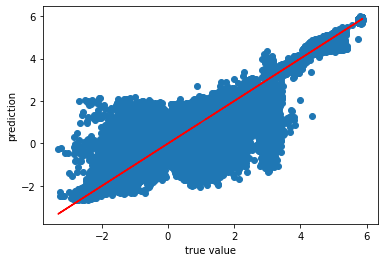

In [241]:
Cat_model = fit_and_eval(CatBoostRegressor(), X_train, y_train, X_val, y_val)

#### Evaluation

Results on the validation set:

- R2 score: 0.932
- RMSE: 0.516
- MAE: 0.311
- Training time: 170 seconds (= 3 minutes)

The XGB regression shows better performance than XGB regression model. R2 score of 0.932 is slightly higher than R2 score of XGB regression, which was 0.929. RMSE and MAE also got slightly lower compared to the error values of XGB Regression. Also, there is no sign of overfitting since the train result and validation result are almost equal. The training time was almost same as that of XGB  but still faster than Random Forest: It took about 3 minutes for modeling. This is, by far, the best model with short fitting time.

### 5.6 Keras Neural Networks

Last model is Keras neural network model. We will create a function for the fitting and evaluating the keras model with the nnet_preprocessing function. For the model, we will:
- add 1 input layer, 5 hidden layers, and 1 output layers
- use LeakyReLU for the activation
- use Batch Normalization
- use 10% dropout after each step 

In [243]:
def fit_eval_nn(X_tr, y_tr, X_v, y_v, epoch, batch):
    '''
    This function:
    1. Creates the sequential keras model with multiple layers
    2. Compile and fit the model
    3. Make prediction based on the fitted model
    4. Report the training time in seconds
    5. Report the results for evaluation (R2 Score, Root Mean Squared Error(RMSE), Mean Absolute Error(MAE))
    6. Plot the scatter plot for the validation prediction and best fit line
    7. Plot the loss curve for the model training procedure
    8. Return history of model fitting
    
    Input:
    X_tr: train dataset for features (X)
    y_tr: train dataset for target variable (y)
    X_v: validation dataset for features (X)
    y_v: validation dataset for target variable (y)  
    epoch: integer for epochs
    batch: integer for batch size
    
    Output:
    Training time: seconds
    Result Report: R2 score, RMSE, MAE
    Scatter Plot
    Loss Plot
    history: record of model fitting process 
    
    '''
    # Create Sequential model 
    # Each layer will have LeakyReLU as activation and BatchNormalization
    model = Sequential()
    
    # Input Layer 
    # Input Shape = (16, ) since X_train has 16 columns
    model.add(Dense(256, input_shape = (16,)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 5 Hidden Layers
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))    
    
    # Output layer
    # Activation = 'linear' since this is a linear regression
    model.add(Dense(1,activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error',optimizer= Adam(1e-4), metrics=['mae'])
    
    # Record the fitting start time
    start = time.time()
    
    # Fit model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_v, y_v), 
                        epochs = epoch, 
                        batch_size = batch)
    
    # Record the fitting end time
    stop = time.time()
    
    # Return Training time in seconds
    print(f"Training time: {stop - start}s")
    
    # Prediction based on the fitted model 
    tr_pred = model.predict(X_tr)
    val_pred = model.predict(X_v)
    
    # Report Results (R2, RMSE, MAE) 
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Train MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    print('')
    
    # Plot the fitted line and the prediction
    print('Prediction')
    plt.scatter(y_v,val_pred)
    plt.plot(y_v, y_v, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    plt.show()
    print('')
    
    # Plot the loss curve 
    print('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()
    
    # Return history of  the fitted model
    return history

Batch size is determined based on the training time. Training time was aimed to be minimized while maintaining more than 1000 iterations per epoch.

Epoch 1/20
1365/1365 [==============================] - 189s 138ms/step - loss: 1.2034 - mae: 0.8432 - val_loss: 0.4930 - val_mae: 0.4898
Epoch 2/20
1365/1365 [==============================] - 181s 133ms/step - loss: 0.6142 - mae: 0.5757 - val_loss: 0.4127 - val_mae: 0.4300
Epoch 3/20
1365/1365 [==============================] - 182s 134ms/step - loss: 0.5060 - mae: 0.5119 - val_loss: 0.3806 - val_mae: 0.3936
Epoch 4/20
1365/1365 [==============================] - 182s 133ms/step - loss: 0.4429 - mae: 0.4694 - val_loss: 0.3434 - val_mae: 0.3668
Epoch 5/20
1365/1365 [==============================] - 183s 134ms/step - loss: 0.4044 - mae: 0.4416 - val_loss: 0.3275 - val_mae: 0.3528
Epoch 6/20
1365/1365 [==============================] - 185s 136ms/step - loss: 0.3799 - mae: 0.4228 - val_loss: 0.3111 - val_mae: 0.3403
Epoch 7/20
1365/1365 [==============================] - 185s 135ms/step - loss: 0.3633 - mae: 0.4098 - val_loss: 0.3028 - val_mae: 0.3361
Epoch 8/20
1365/1365 [============

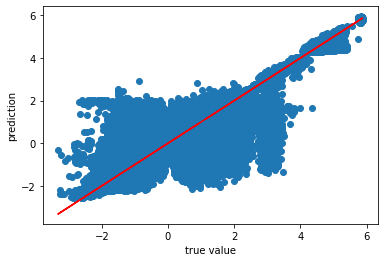


Loss


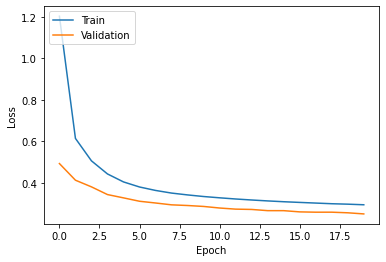

In [246]:
history = fit_eval_nn(X_train, y_train, X_val, y_val, epoch = 20, batch = 2048)

#### Evaluation

Results on the validation set:

- R2 score: 0.936
- RMSE: 0.500
- MAE: 0.296
- Training time: 3786 seconds (= about 1 hour)

The Keras regression shows best performance. Keras R2 score is the highest and error values are the lowest among all the models. The results and the loss curve shows that there is no sign of overfitting. Training time is about an hour, which is pretty long but shows better performance than Random Forest which also took about an hour for training. Therefore, we will choose the Keras model as our final model. 

### 4.7 Final Model

Based on the results, Keras neural network is the regressor that shows the best performance. However, the result shows that the model was still learning: loss curve shows that training and validation loss is still decreasing when the model stopped fitting. 

Therefore, we will try the higher epochs and early stopping to reach the point where loss stabilizes, or the curve becomes amost flat horizontal line. Also, we will add more layers to the model to see if we can enhance the scores even more.

So, for final model tuning, we will:
- Add two more hidden layers to the model
- Add Earlystopping to reduce fitting time and avoid overfitting. 

We will create a new function for this process.

In [247]:
def fit_eval_final(X_tr, y_tr, X_v, y_v, epoch, batch):
    '''
    This function:
    1. Creates the sequential keras model with multiple layers
    2. Compile and fit the model
    3. Make prediction based on the fitted model
    4. Report the training time in seconds
    5. Report the results for evaluation (R2 Score, Root Mean Squared Error(RMSE), Mean Absolute Error(MAE))
    6. Plot the scatter plot for the validation prediction and best fit line
    7. Plot the loss curve for the model training procedure
    8. Return history of model fitting and the fitted model
    
    Input:
    X_tr: train dataset for features (X)
    y_tr: train dataset for target variable (y)
    X_v: validation dataset for features (X)
    y_v: validation dataset for target variable (y)  
    epoch: integer for epochs
    batch: integer for batch size
    
    Output:
    Training time: seconds
    Result Report: R2 score, RMSE, MAE
    Scatter Plot
    Loss Plot
    history: record of model fitting process 
    model: fitted model
    
    '''
    # Create Sequential model 
    # Each layer will have LeakyReLU as activation and BatchNormalization
    model = Sequential()
    
    # Input Layer 
    # Input Shape = (16, ) since X_train has 16 columns
    model.add(Dense(256, input_shape = (16,)))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # 7 Hidden Layers
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))    

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.05))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))  
    
    # Output layer
    # Activation = 'linear' since this is a linear regression
    model.add(Dense(1,activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error',optimizer= Adam(1e-4), metrics=['mae'])
    
    # Define Earlystopping
    stop =  EarlyStopping(monitor = 'val_loss', verbose = 1, mode = 'min', patience = 3)
    
    # Record the fitting start time
    start = time.time()
    
    # Fit model
    history = model.fit(X_tr, y_tr, 
                        validation_data=(X_v, y_v), 
                        epochs = epoch, 
                        batch_size = batch,
                       callbacks = [stop])
    
    # Record the fitting end time
    stop = time.time()
    
    # Return Training time in seconds
    print(f"Training time: {stop - start}s")
    
    # Prediction based on the fitted model 
    tr_pred = model.predict(X_tr)
    val_pred = model.predict(X_v)
    
    # Report Results (R2, RMSE, MAE) 
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Train MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    print('')
    
    # Plot the fitted line and the prediction
    print('Prediction')
    plt.scatter(y_v,val_pred)
    plt.plot(y_v, y_v, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    plt.show()
    print('')
    
    # Plot the loss curve 
    print('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()
    
    # Return history of  the fitted model
    return history, model

We will maintain the batch size as same as the first keras model but increase the epoch size to 100. If the Earlystopper determines that model is overfitting, the process will be stopped before it reaches the set epoch. 

Epoch 1/100
1365/1365 [==============================] - 302s 221ms/step - loss: 1.2915 - mae: 0.9030 - val_loss: 0.5065 - val_mae: 0.5075
Epoch 2/100
1365/1365 [==============================] - 305s 223ms/step - loss: 0.6115 - mae: 0.5772 - val_loss: 0.3899 - val_mae: 0.3897
Epoch 3/100
1365/1365 [==============================] - 305s 223ms/step - loss: 0.4983 - mae: 0.5093 - val_loss: 0.3503 - val_mae: 0.3726
Epoch 4/100
1365/1365 [==============================] - 309s 227ms/step - loss: 0.4386 - mae: 0.4687 - val_loss: 0.3222 - val_mae: 0.3547
Epoch 5/100
1365/1365 [==============================] - 302s 221ms/step - loss: 0.4035 - mae: 0.4436 - val_loss: 0.3128 - val_mae: 0.3446
Epoch 6/100
1365/1365 [==============================] - 301s 220ms/step - loss: 0.3820 - mae: 0.4278 - val_loss: 0.3013 - val_mae: 0.3339
Epoch 7/100
1365/1365 [==============================] - 298s 218ms/step - loss: 0.3668 - mae: 0.4164 - val_loss: 0.2912 - val_mae: 0.3270
Epoch 8/100
1365/1365 [====

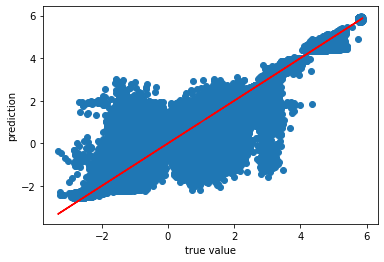


Loss


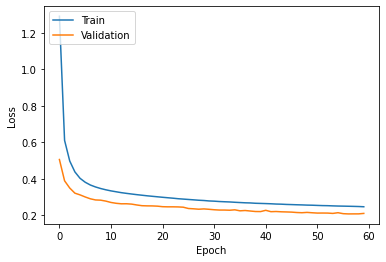

In [248]:
history_f, model_f = fit_eval_final(X_train, y_train, X_val, y_val, epoch = 100, batch = 2048)

Results on the validation set:

- R2 score: 0.946
- RMSE: 0.459
- MAE: 0.262
- Training time: 15595 seconds (= 4 hours)

The tuned Keras R2 score is the highest and error values are the lowest among all the models. The results and the loss curve shows that there is no sign of overfitting but the R2 is slightly lower (difference of 0.002) and error values are slightly higher than the train set (difference of ~ 0.01). This means there is a slight overfitting but it is acceptable since the difference in very small.

## 5. Evaluation

We will evaluate the final model on test set. Since we will only evaluate the model for once, we will not create a function for this process.

Prediction time: 89.96339583396912s for 931816 predictions

Result Report

Test R2 Score: 0.9461544983983261

Test RMSE: 0.45984758219441946

Test MAE: 0.26220035989513957

Prediction


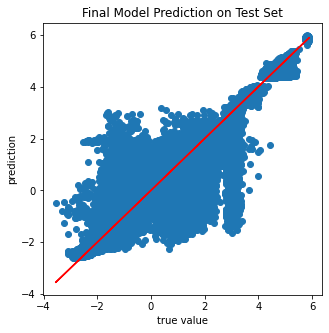

In [265]:
# Record the fitting start time
start = time.time()

# final model prediction on test set 
test_pred = model_f.predict(X_test)

# Record the fitting end time
stop = time.time()

# Return Prediction time in seconds
print(f'Prediction time: {stop - start}s for {len(X_test.index)} predictions')
print('')

# Report Results
print('Result Report')
print('')
print(f'Test R2 Score: {r2_score(y_test, test_pred)}')
print('')
print(f'Test RMSE: {mean_squared_error(y_test, test_pred, squared = False)}')
print('')
print(f'Test MAE: {mean_absolute_error(y_test, test_pred)}')
print('')

# Plot the fitted line and the prediction
print('Prediction')

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(y_test,test_pred)
ax.plot(y_test, y_test, c="Red")
ax.set_title('Final Model Prediction on Test Set')
ax.set_xlabel('true value')
ax.set_ylabel('prediction')

# save figure
fig.savefig('Image/Final_Model_Results')

### Conclusion

Based on the results on the test set:
- The R2 score on the test set is 0.946. This means the predicted target variable on the test set shows high positive correlation with the actual test target variable. Also, R2 score of 0.946 means approximately 94.6% of the observed variation can be explained by the final keras model.


- RMSE of 0.460 and MAE of 0.262 are both low values. This means the final model can relatively predict the target variable accurately.


- Metrics for the test set is very close those of the train and validation set. This means the final model is generalized and available to be applied to the real-world coupling constant prediction without biased.


- When neccessary informations (features in train_df2) are provided, final model can give accurate prediction on the target variable in less than a second for each combination of the atom inside the molecule: It took about 90 seconds for more than 90k  predictions on test set. This will significantly reduce the cost and time it takes for predicting the scalar coupling constant, which takes days to even weeks for one molecule when traditional calculation method is used. Therefore, I strongly recommend researchers to apply this model to their NMR research process to speed up their research process.


- As a reminder, current target variable has gone through the cubic root transformation. Therefore, when the prediction result is generated, the values must be cubed for the real-world application.

### Next Steps

- **Data Collection and Feature Engineering:** Additional feature engineering can be done to enhance the accuracy of the model prediction even better. Features like type of hybridization, which is the new hybrid created by mixing different atoms, affects the structure and the properties of the molecule, which is definitely a useful factor for explaining the property of the molecule. Also, gathering even more data can even create even more generalizable and accurate model. Therefore, more data scrapping on different molecules is recommended.


- **Divide into Subset**: The analysis and prediction was made on the whole train_df in this project: overall performance does not explain how model works on each type of couplings. Therefore, dividing up the data into subset based on 8 different coupling types will allow to fine-tune model specifically targeting one coupling type. Also, models we previously used might perform better on one type while shows worse performance on other types. By dividing the dataset and model them, we can build further insight on which model and hyperparameters works best for each type of couplings and enhance the prediction accuracy even further.

## 6. Save Model

We will save this final model so it can be loaded anytime.

In [271]:
# save trained final model
model_f.save('Final_Model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Final_Model\assets


We will load the saved model and check on test set to see if model is properly saved.

In [272]:
# Load saved model
new_model = load_model('Final_Model')

In [273]:
# Check on Test Set

# final model prediction on test set 
test_pred2 = new_model.predict(X_test)

# Report Results
print('Result Report')
print('')
print(f'Test R2 Score: {r2_score(y_test, test_pred2)}')
print('')
print(f'Test RMSE: {mean_squared_error(y_test, test_pred2, squared = False)}')
print('')
print(f'Test MAE: {mean_absolute_error(y_test, test_pred2)}')
print('')


Result Report

Test R2 Score: 0.9461544983983261

Test RMSE: 0.45984758219441946

Test MAE: 0.26220035989513957



Great! Now the trained model can be used without rerunning the whole notebook.